In [1]:
import logging
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm

sys.path.append(os.path.abspath("../.."))
from spectrum.utils.random import set_random_state
from spectrum.models import SpectralResidual
from spectrum.dataset import SRYaHooDataset

logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.edgecolor": "0.3",
        "axes.linewidth": 0.8,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.titleweight": "bold",
        "legend.fontsize": 10,
        "figure.dpi": 120,
        "legend.frameon": False,
    }
)

set_random_state(42)

In [2]:
selected_ids = [4, 17, 33]

results_dir = "../../results/models/sr"
os.makedirs(results_dir, exist_ok=True)


def find_best_threshold(scores, true_labels, thresholds=None):
    if thresholds is None:
        # use percentiles as candidate thresholds
        thresholds = [np.percentile(scores, p) for p in range(50, 100, 1)]
        # add some extra threshold points
        thresholds.extend([np.percentile(scores, p) for p in [99.5, 99.9]])

    best_f1 = 0
    best_threshold = thresholds[0]
    best_metrics = {}

    for threshold in thresholds:
        pred_labels = (scores > threshold).astype(int)

        # calculate confusion matrix
        TP = ((true_labels == 1) & (pred_labels == 1)).sum()
        FP = ((true_labels == 0) & (pred_labels == 1)).sum()
        TN = ((true_labels == 0) & (pred_labels == 0)).sum()
        FN = ((true_labels == 1) & (pred_labels == 0)).sum()

        # calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'fnr': fnr,
                'fpr': fpr,
                'tp': TP,
                'fp': FP,
                'tn': TN,
                'fn': FN
            }

    return best_threshold, best_metrics


def process_single_id(dataset_id):
    print(f"processing: {dataset_id}")

    train_data = SRYaHooDataset(
        _id=dataset_id
    )
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{dataset_id}.csv")

    print("  training model...")
    model = SpectralResidual()

    print("  anomaly detection...")
    start_time = time.time()
    scores = model.predict(test_data['value'])
    scoring_time = time.time() - start_time

    train_len = len(pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")['value'])
    test_len = len(complete_data) - train_len
    test_true_labels = complete_data["label"][train_len:train_len + test_len].to_numpy()
    scores_array = scores

    print("  finding best threshold...")
    best_threshold, best_metrics = find_best_threshold(scores_array, test_true_labels)

    complete_values = complete_data["value"].to_numpy()
    complete_labels = complete_data["label"].to_numpy()
    complete_timestamps = complete_data["timestamp"] if "timestamp" in complete_data.columns else range(
        len(complete_values))

    complete_predictions = np.zeros(len(complete_values))
    complete_predictions[train_len:train_len + test_len] = (scores_array > best_threshold).astype(int)

    result_df = pd.DataFrame({
        'timestamp': complete_timestamps,
        'value': complete_values,
        'label': complete_labels,
        'predicted': complete_predictions,
        'anomaly_score': np.concatenate(
            [np.zeros(train_len), scores_array, np.zeros(len(complete_values) - train_len - test_len)])
    })

    output_file = os.path.join(results_dir, f"{dataset_id}.csv")
    result_df.to_csv(output_file, index=False)
    print(f"  results saved to: {output_file}")

    return {
        'id': dataset_id,
        'training_time': 0,
        'testing_time': scoring_time,
        'total_time': scoring_time,
        'train_samples': len(train_data),
        'test_samples': test_len,
        'best_threshold': best_threshold,
        **best_metrics
    }


all_results = []
print(f"processing {len(selected_ids)} datasets...")

for selected_id in tqdm(selected_ids, desc="processing"):
    try:
        result = process_single_id(selected_id)
        all_results.append(result)

        print(f"  ID {selected_id} completed:")
        print(f"    best_threshold: {result['best_threshold']:.4f}")
        print(f"    f1: {result['f1']:.4f}")
        print(f"    precision: {result['precision']:.4f}")
        print(f"    recall: {result['recall']:.4f}")
        print(f"    accuracy: {result['accuracy']:.4f}")

    except Exception as e:
        print(f"  processing {selected_id} failed: {str(e)}")
        import traceback

        traceback.print_exc()
        continue

if all_results:
    summary_df = pd.DataFrame(all_results)
    summary_file = os.path.join(results_dir, "sr.csv")
    summary_df.to_csv(summary_file, index=False)
    print(f"summary results saved to: {summary_file}")

    print("\n" + "=" * 80)
    print("Spectral Residual anomaly detection results")
    print("=" * 80)
    print(f"processed {len(all_results)} datasets")
    print(f"average F1: {summary_df['f1'].mean():.4f} ± {summary_df['f1'].std():.4f}")
    print(f"average precision: {summary_df['precision'].mean():.4f} ± {summary_df['precision'].std():.4f}")
    print(f"average recall: {summary_df['recall'].mean():.4f} ± {summary_df['recall'].std():.4f}")
    print(f"average accuracy: {summary_df['accuracy'].mean():.4f} ± {summary_df['accuracy'].std():.4f}")
    print(f"average training time: {summary_df['training_time'].mean():.2f}s")
    print(f"average scoring time: {summary_df['testing_time'].mean():.2f}s")
    print("=" * 80)

    print("details:")
    display_cols = ['id', 'f1', 'precision', 'recall', 'accuracy', 'best_threshold', 'tp', 'fp', 'tn', 'fn']
    print(summary_df[display_cols].round(4))
else:
    print("no results")

processing 3 datasets...


processing: 100%|██████████| 3/3 [00:00<00:00, 28.32it/s]

processing: 4
  training model...
  anomaly detection...
  finding best threshold...
  results saved to: ../../results/models/sr/4.csv
  ID 4 completed:
    best_threshold: 0.1500
    f1: 0.5882
    precision: 0.6250
    recall: 0.5556
    accuracy: 0.9902
processing: 17
  training model...
  anomaly detection...
  finding best threshold...
  results saved to: ../../results/models/sr/17.csv
  ID 17 completed:
    best_threshold: 0.0368
    f1: 0.5489
    precision: 0.5088
    recall: 0.5959
    accuracy: 0.7992
processing: 33
  training model...
  anomaly detection...
  finding best threshold...
  results saved to: ../../results/models/sr/33.csv
  ID 33 completed:
    best_threshold: 0.3782
    f1: 1.0000
    precision: 1.0000
    recall: 1.0000
    accuracy: 1.0000
summary results saved to: ../../results/models/sr/sr.csv

Spectral Residual anomaly detection results
processed 3 datasets
average F1: 0.7124 ± 0.2499
average precision: 0.7113 ± 0.2567
average recall: 0.7171 ± 0.2458
avera

In [3]:
# SR变换可视化分析
import matplotlib.pyplot as plt
from spectrum.models.sr.saliency import Saliency
from spectrum.models.sr.utils import marge_series, series_filter

def visualize_sr_transformation(dataset_id, model=None):
    """
    可视化SR变换的完整过程
    
    Args:
        dataset_id: 数据集ID
        model: SpectralResidual模型实例（可选）
    """
    
    # 加载数据
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{dataset_id}.csv")
    
    values = test_data['value'].to_numpy()
    
    # 创建或使用提供的模型
    if model is None:
        model = SpectralResidual()
    
    # 获取异常分数
    anomaly_scores = model.predict(test_data['value'])
    
    # 获取中间变换结果
    saliency = Saliency(
        amp_window_size=model.mag_window_size,
        series_window_size=model.window_size,
        score_window_size=model.score_window_size
    )
    
    # 1. 扩展序列
    extended_series = marge_series(values, saliency.series_window_size, saliency.series_window_size)
    
    # 2. 频谱残差变换
    spectral_residual = saliency.transform_spectral_residual(extended_series)
    spectral_residual_original = spectral_residual[:len(values)]
    
    # 3. 滤波后的幅度
    filtered_mag = series_filter(spectral_residual_original, saliency.score_window_size)
    
    # 创建可视化
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'SR变换过程分析 - 数据集 {dataset_id}', fontsize=16, fontweight='bold')
    
    time_axis = np.arange(len(values))
    extended_time_axis = np.arange(len(extended_series))
    
    # 子图1: 原始数据 vs 扩展数据
    axes[0, 0].plot(time_axis, values, 'b-', linewidth=2, label='Original Data', alpha=0.8)
    axes[0, 0].plot(extended_time_axis, extended_series, 'r--', linewidth=1, label='Extended Data', alpha=0.6)
    axes[0, 0].axvline(x=len(values)-1, color='gray', linestyle=':', alpha=0.7, label='Extension Boundary')
    axes[0, 0].set_title('Original vs Extended Data')
    axes[0, 0].set_xlabel('Time Points')
    axes[0, 0].set_ylabel('Values')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 子图2: 频谱残差
    axes[0, 1].plot(time_axis, spectral_residual_original, 'g-', linewidth=2, label='Spectral Residual')
    axes[0, 1].plot(time_axis, filtered_mag, 'orange', linewidth=2, label='Filtered Magnitude', alpha=0.8)
    axes[0, 1].set_title('Spectral Residual Transform')
    axes[0, 1].set_xlabel('Time Points')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 子图3: 异常分数
    axes[1, 0].plot(time_axis, anomaly_scores, 'purple', linewidth=2, label='Anomaly Scores')
    axes[1, 0].fill_between(time_axis, anomaly_scores, alpha=0.3, color='purple')
    axes[1, 0].set_title('Anomaly Scores')
    axes[1, 0].set_xlabel('Time Points')
    axes[1, 0].set_ylabel('Anomaly Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 子图4: 标准化对比
    def standardize(data):
        return (data - np.mean(data)) / (np.std(data) + 1e-8)
    
    norm_values = standardize(values)
    norm_spectral = standardize(spectral_residual_original)
    norm_anomaly = standardize(anomaly_scores)
    
    axes[1, 1].plot(time_axis, norm_values, 'b-', linewidth=2, label='Original Data', alpha=0.8)
    axes[1, 1].plot(time_axis, norm_spectral, 'g-', linewidth=2, label='Spectral Residual', alpha=0.8)
    axes[1, 1].plot(time_axis, norm_anomaly, 'purple', linewidth=2, label='Anomaly Scores', alpha=0.8)
    axes[1, 1].set_title('Normalized Comparison')
    axes[1, 1].set_xlabel('Time Points')
    axes[1, 1].set_ylabel('Normalized Values')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=== SR Transform Statistics ===")
    print(f"Data Length: {len(values)}")
    print(f"Original Data Range: [{np.min(values):.4f}, {np.max(values):.4f}]")
    print(f"Spectral Residual Range: [{np.min(spectral_residual_original):.4f}, {np.max(spectral_residual_original):.4f}]")
    print(f"Anomaly Scores Range: [{np.min(anomaly_scores):.4f}, {np.max(anomaly_scores):.4f}]")
    print(f"Mean Anomaly Score: {np.mean(anomaly_scores):.4f}")
    
    return fig

def visualize_anomaly_detection_results(dataset_id, threshold=None):
    """
    可视化异常检测结果
    """
    # 加载数据
    test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
    complete_data = pl.read_csv(f"../../datasets/Yahoo/data/A1Benchmark/{dataset_id}.csv")
    
    values = test_data['value'].to_numpy()
    
    # 获取真实标签
    train_len = len(pl.read_csv(f"../../datasets/Yahoo/train/A1/{dataset_id}.csv")['value'])
    test_len = len(complete_data) - train_len
    true_labels = complete_data["label"][train_len:train_len + test_len].to_numpy()
    
    # 获取异常分数
    model = SpectralResidual()
    anomaly_scores = model.predict(test_data['value'])
    
    # 如果没有提供阈值，使用最佳阈值
    if threshold is None:
        threshold, _ = find_best_threshold(anomaly_scores, true_labels)
    
    # 识别异常点
    predicted_anomalies = anomaly_scores > threshold
    true_anomalies = true_labels == 1
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'Anomaly Detection Results - Dataset {dataset_id}', fontsize=16, fontweight='bold')
    
    time_axis = np.arange(len(values))
    
    # 子图1: 原始数据与真实异常点
    axes[0].plot(time_axis, values, 'b-', linewidth=2, label='Original Data', alpha=0.8)
    if np.any(true_anomalies):
        axes[0].scatter(time_axis[true_anomalies], values[true_anomalies], 
                       color='red', s=60, label=f'True Anomalies ({np.sum(true_anomalies)})', zorder=5)
    axes[0].set_title('Original Data with True Anomalies')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Values')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 子图2: 原始数据与预测异常点
    axes[1].plot(time_axis, values, 'b-', linewidth=2, label='Original Data', alpha=0.8)
    if np.any(predicted_anomalies):
        axes[1].scatter(time_axis[predicted_anomalies], values[predicted_anomalies], 
                       color='orange', s=60, label=f'Predicted Anomalies ({np.sum(predicted_anomalies)})', zorder=5)
    axes[1].set_title(f'Original Data with Predicted Anomalies (Threshold: {threshold:.4f})')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Values')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 子图3: 异常分数与阈值
    axes[2].plot(time_axis, anomaly_scores, 'purple', linewidth=2, label='Anomaly Scores')
    axes[2].fill_between(time_axis, anomaly_scores, alpha=0.3, color='purple')
    axes[2].axhline(y=threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({threshold:.4f})')
    
    # 高亮异常区域
    if np.any(predicted_anomalies):
        axes[2].fill_between(time_axis, threshold, anomaly_scores, 
                            where=(anomaly_scores > threshold), 
                            color='red', alpha=0.3, label='Anomaly Regions')
    
    axes[2].set_title('Anomaly Scores and Threshold')
    axes[2].set_xlabel('Time Points')
    axes[2].set_ylabel('Anomaly Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 计算性能指标
    TP = np.sum((true_anomalies == 1) & (predicted_anomalies == 1))
    FP = np.sum((true_anomalies == 0) & (predicted_anomalies == 1))
    TN = np.sum((true_anomalies == 0) & (predicted_anomalies == 0))
    FN = np.sum((true_anomalies == 1) & (predicted_anomalies == 0))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    print("=== Detection Results ===")
    print(f"True Anomalies: {np.sum(true_anomalies)}")
    print(f"Predicted Anomalies: {np.sum(predicted_anomalies)}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"True Negatives: {TN}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    return fig

def compare_multiple_datasets(dataset_ids=None):
    """
    比较多个数据集的SR变换结果
    """
    if dataset_ids is None:
        dataset_ids = selected_ids
    
    fig, axes = plt.subplots(len(dataset_ids), 2, figsize=(16, 6*len(dataset_ids)))
    if len(dataset_ids) == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('SR Transform Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    model = SpectralResidual()
    
    for i, dataset_id in enumerate(dataset_ids):
        # 加载数据
        test_data = pl.read_csv(f"../../datasets/Yahoo/test/A1/{dataset_id}.csv")
        values = test_data['value'].to_numpy()
        
        # 获取异常分数
        anomaly_scores = model.predict(test_data['value'])
        
        time_axis = np.arange(len(values))
        
        # 原始数据
        axes[i, 0].plot(time_axis, values, 'b-', linewidth=2, label=f'Dataset {dataset_id}')
        axes[i, 0].set_title(f'Original Data - Dataset {dataset_id}')
        axes[i, 0].set_xlabel('Time Points')
        axes[i, 0].set_ylabel('Values')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].legend()
        
        # 异常分数
        axes[i, 1].plot(time_axis, anomaly_scores, 'purple', linewidth=2, label=f'Dataset {dataset_id}')
        axes[i, 1].fill_between(time_axis, anomaly_scores, alpha=0.3, color='purple')
        axes[i, 1].set_title(f'Anomaly Scores - Dataset {dataset_id}')
        axes[i, 1].set_xlabel('Time Points')
        axes[i, 1].set_ylabel('Anomaly Score')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

=== SR变换可视化演示 ===

1. 分析数据集 4 的SR变换过程:


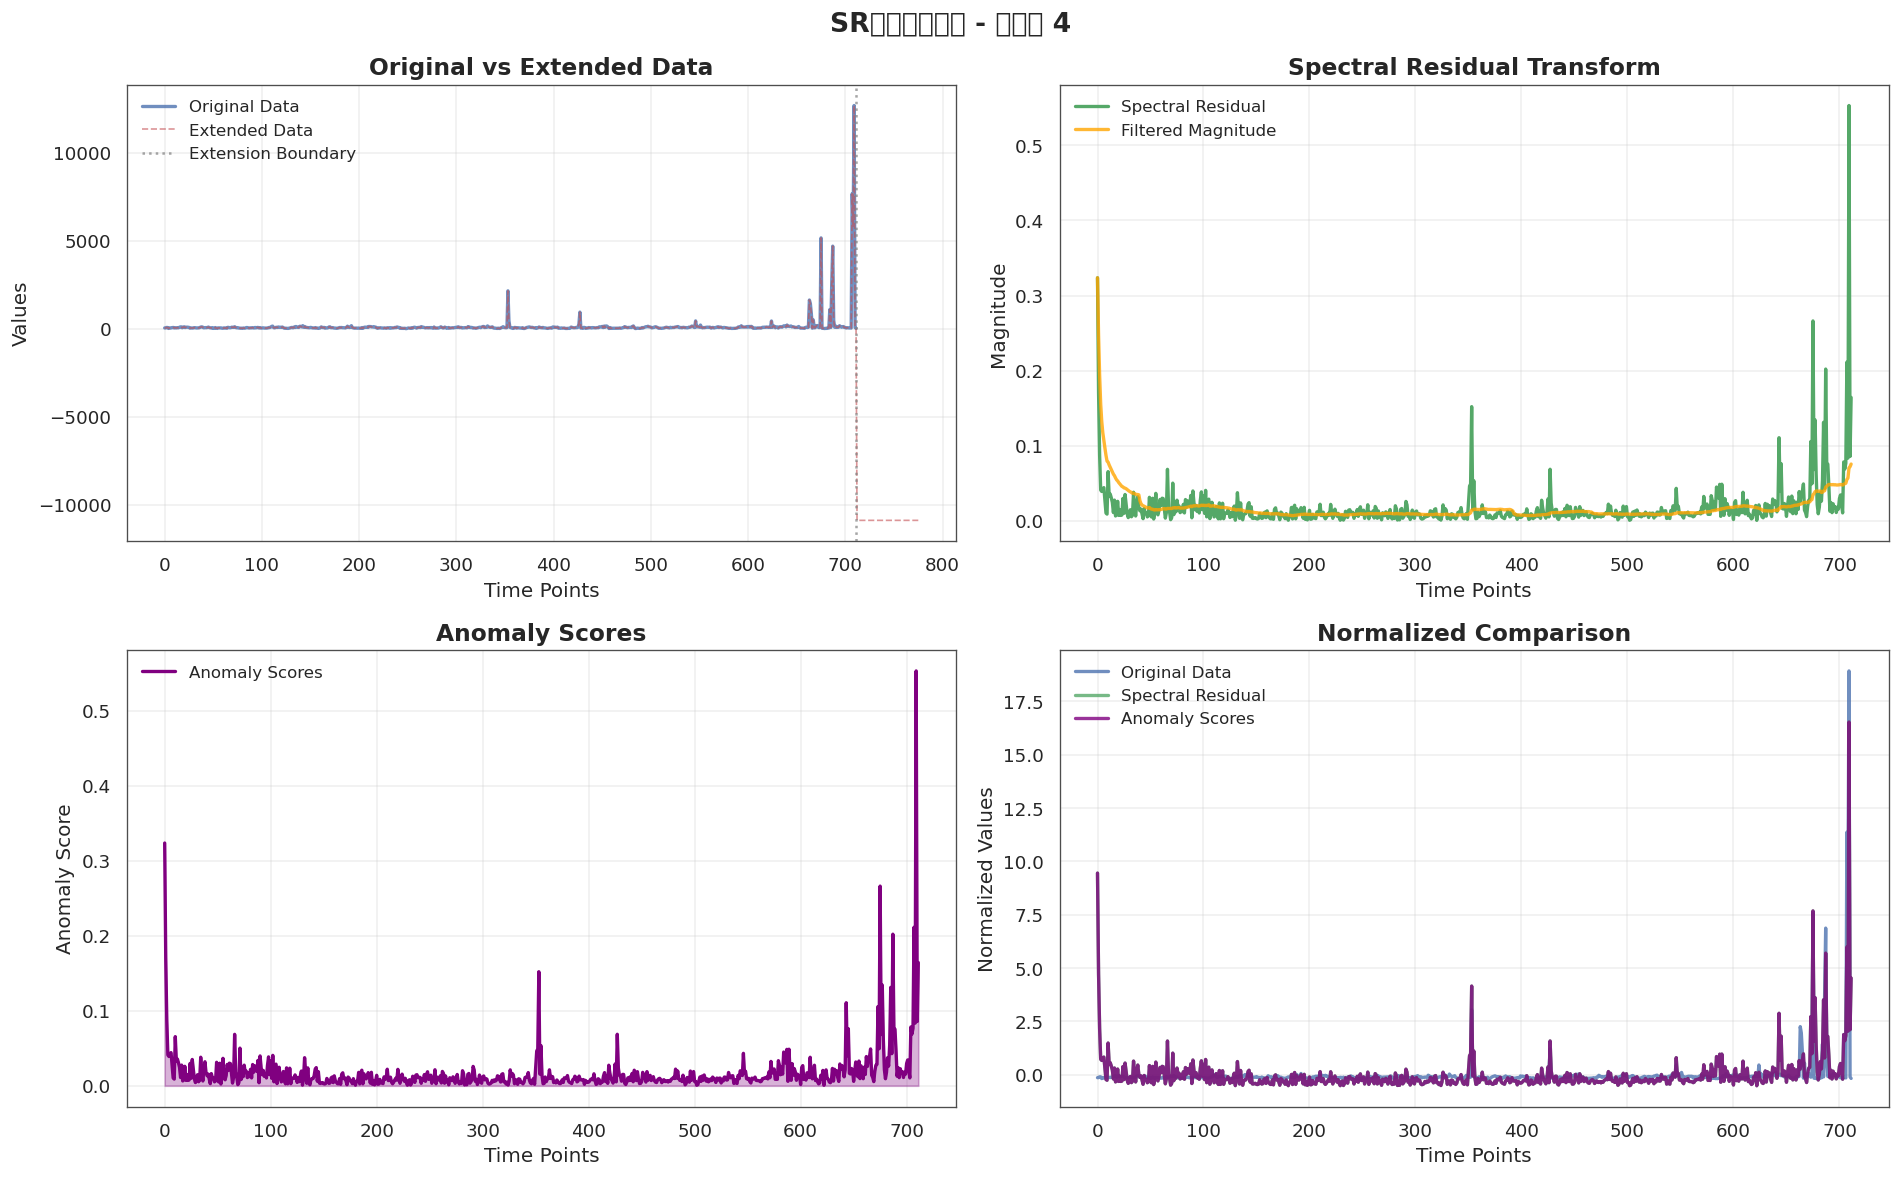

=== SR Transform Statistics ===
Data Length: 712
Original Data Range: [5.0000, 12673.0000]
Spectral Residual Range: [0.0006, 0.5529]
Anomaly Scores Range: [0.0006, 0.5529]
Mean Anomaly Score: 0.0172

2. 分析数据集 4 的异常检测结果:


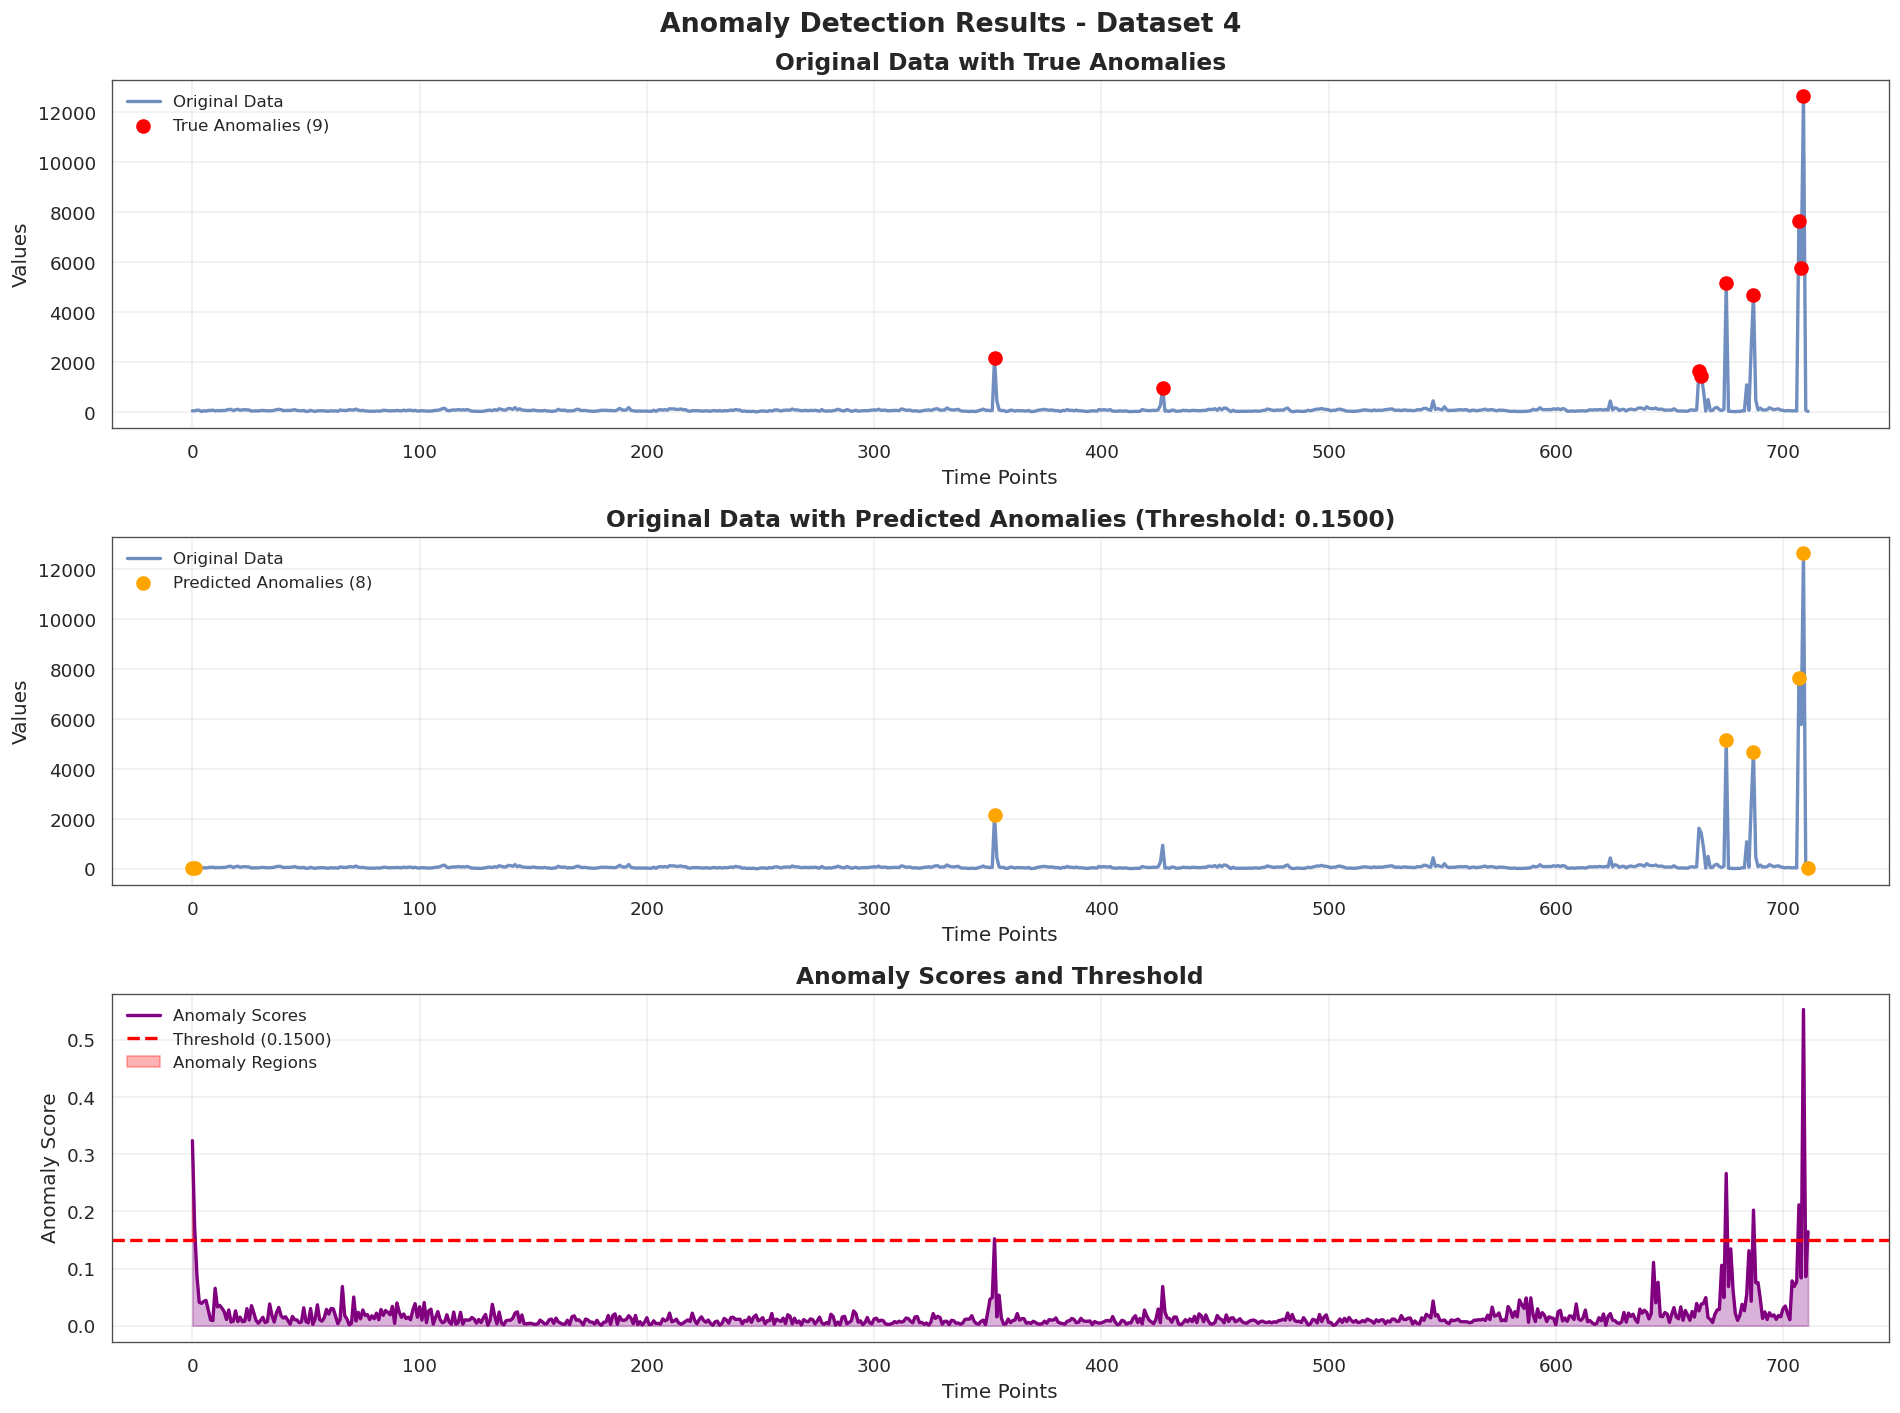

=== Detection Results ===
True Anomalies: 9
Predicted Anomalies: 8
True Positives: 5
False Positives: 3
True Negatives: 700
False Negatives: 4
Precision: 0.6250
Recall: 0.5556
F1-Score: 0.5882
Accuracy: 0.9902

3. 比较所有数据集的结果:


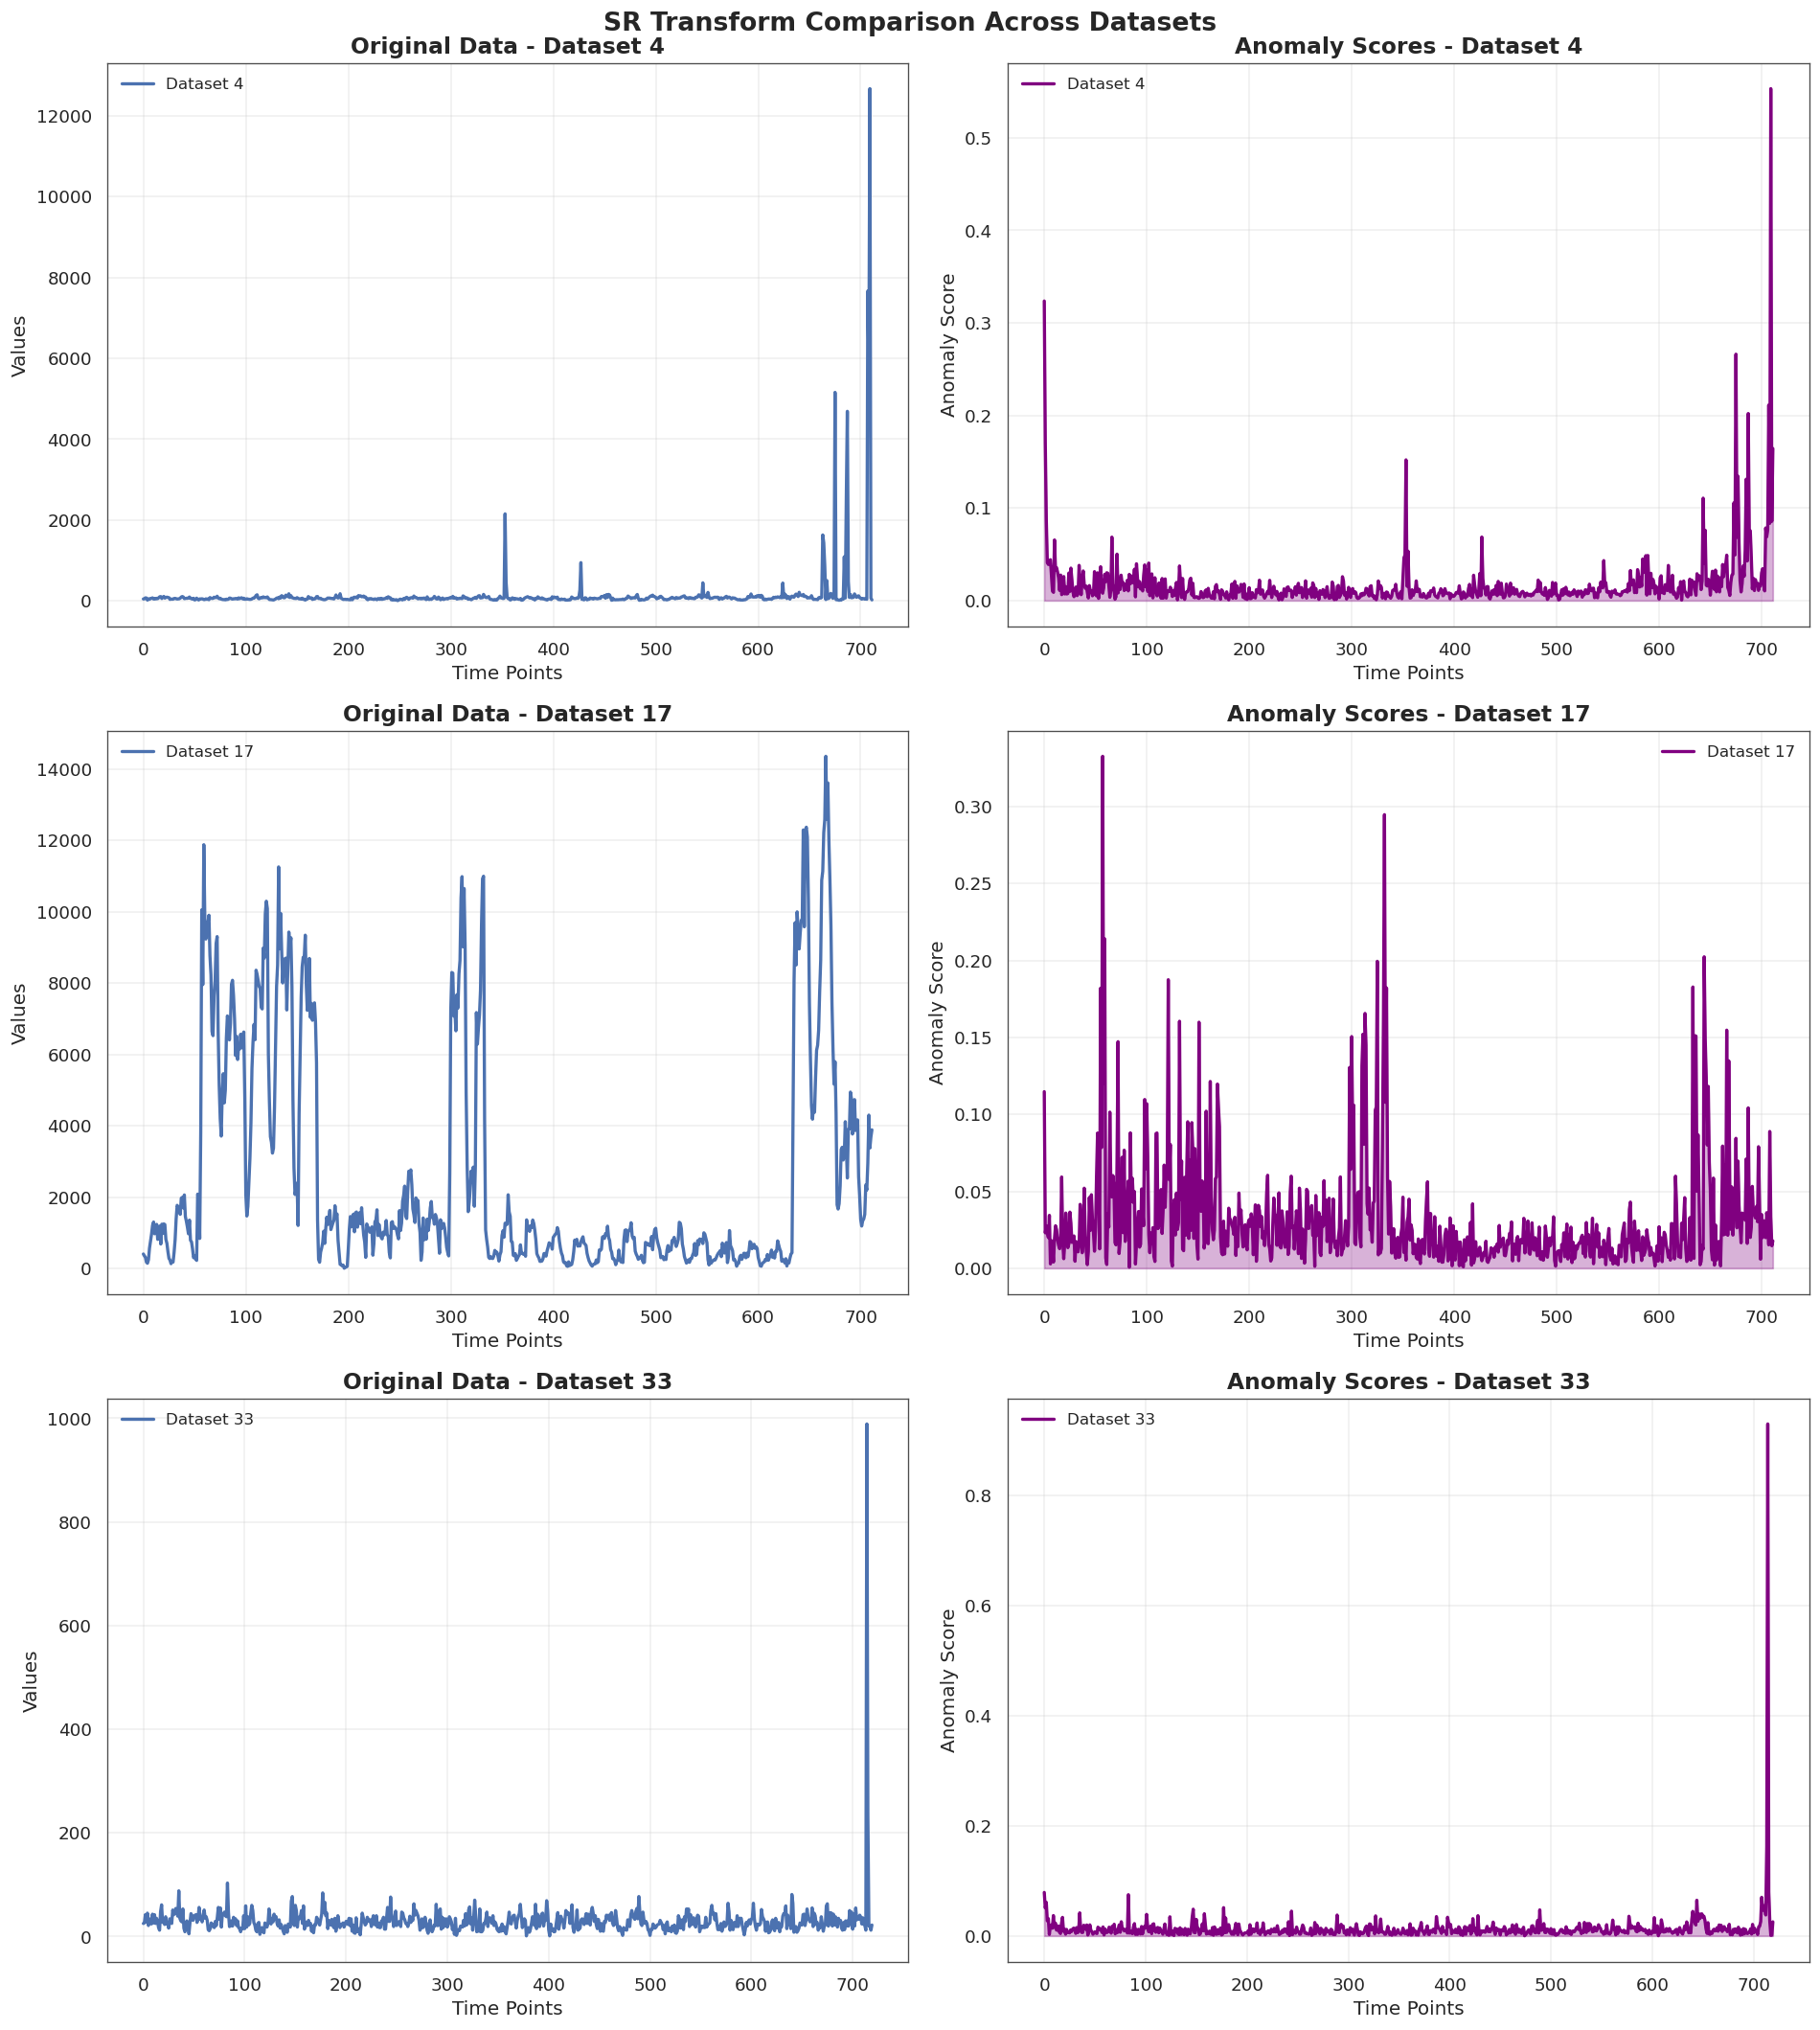

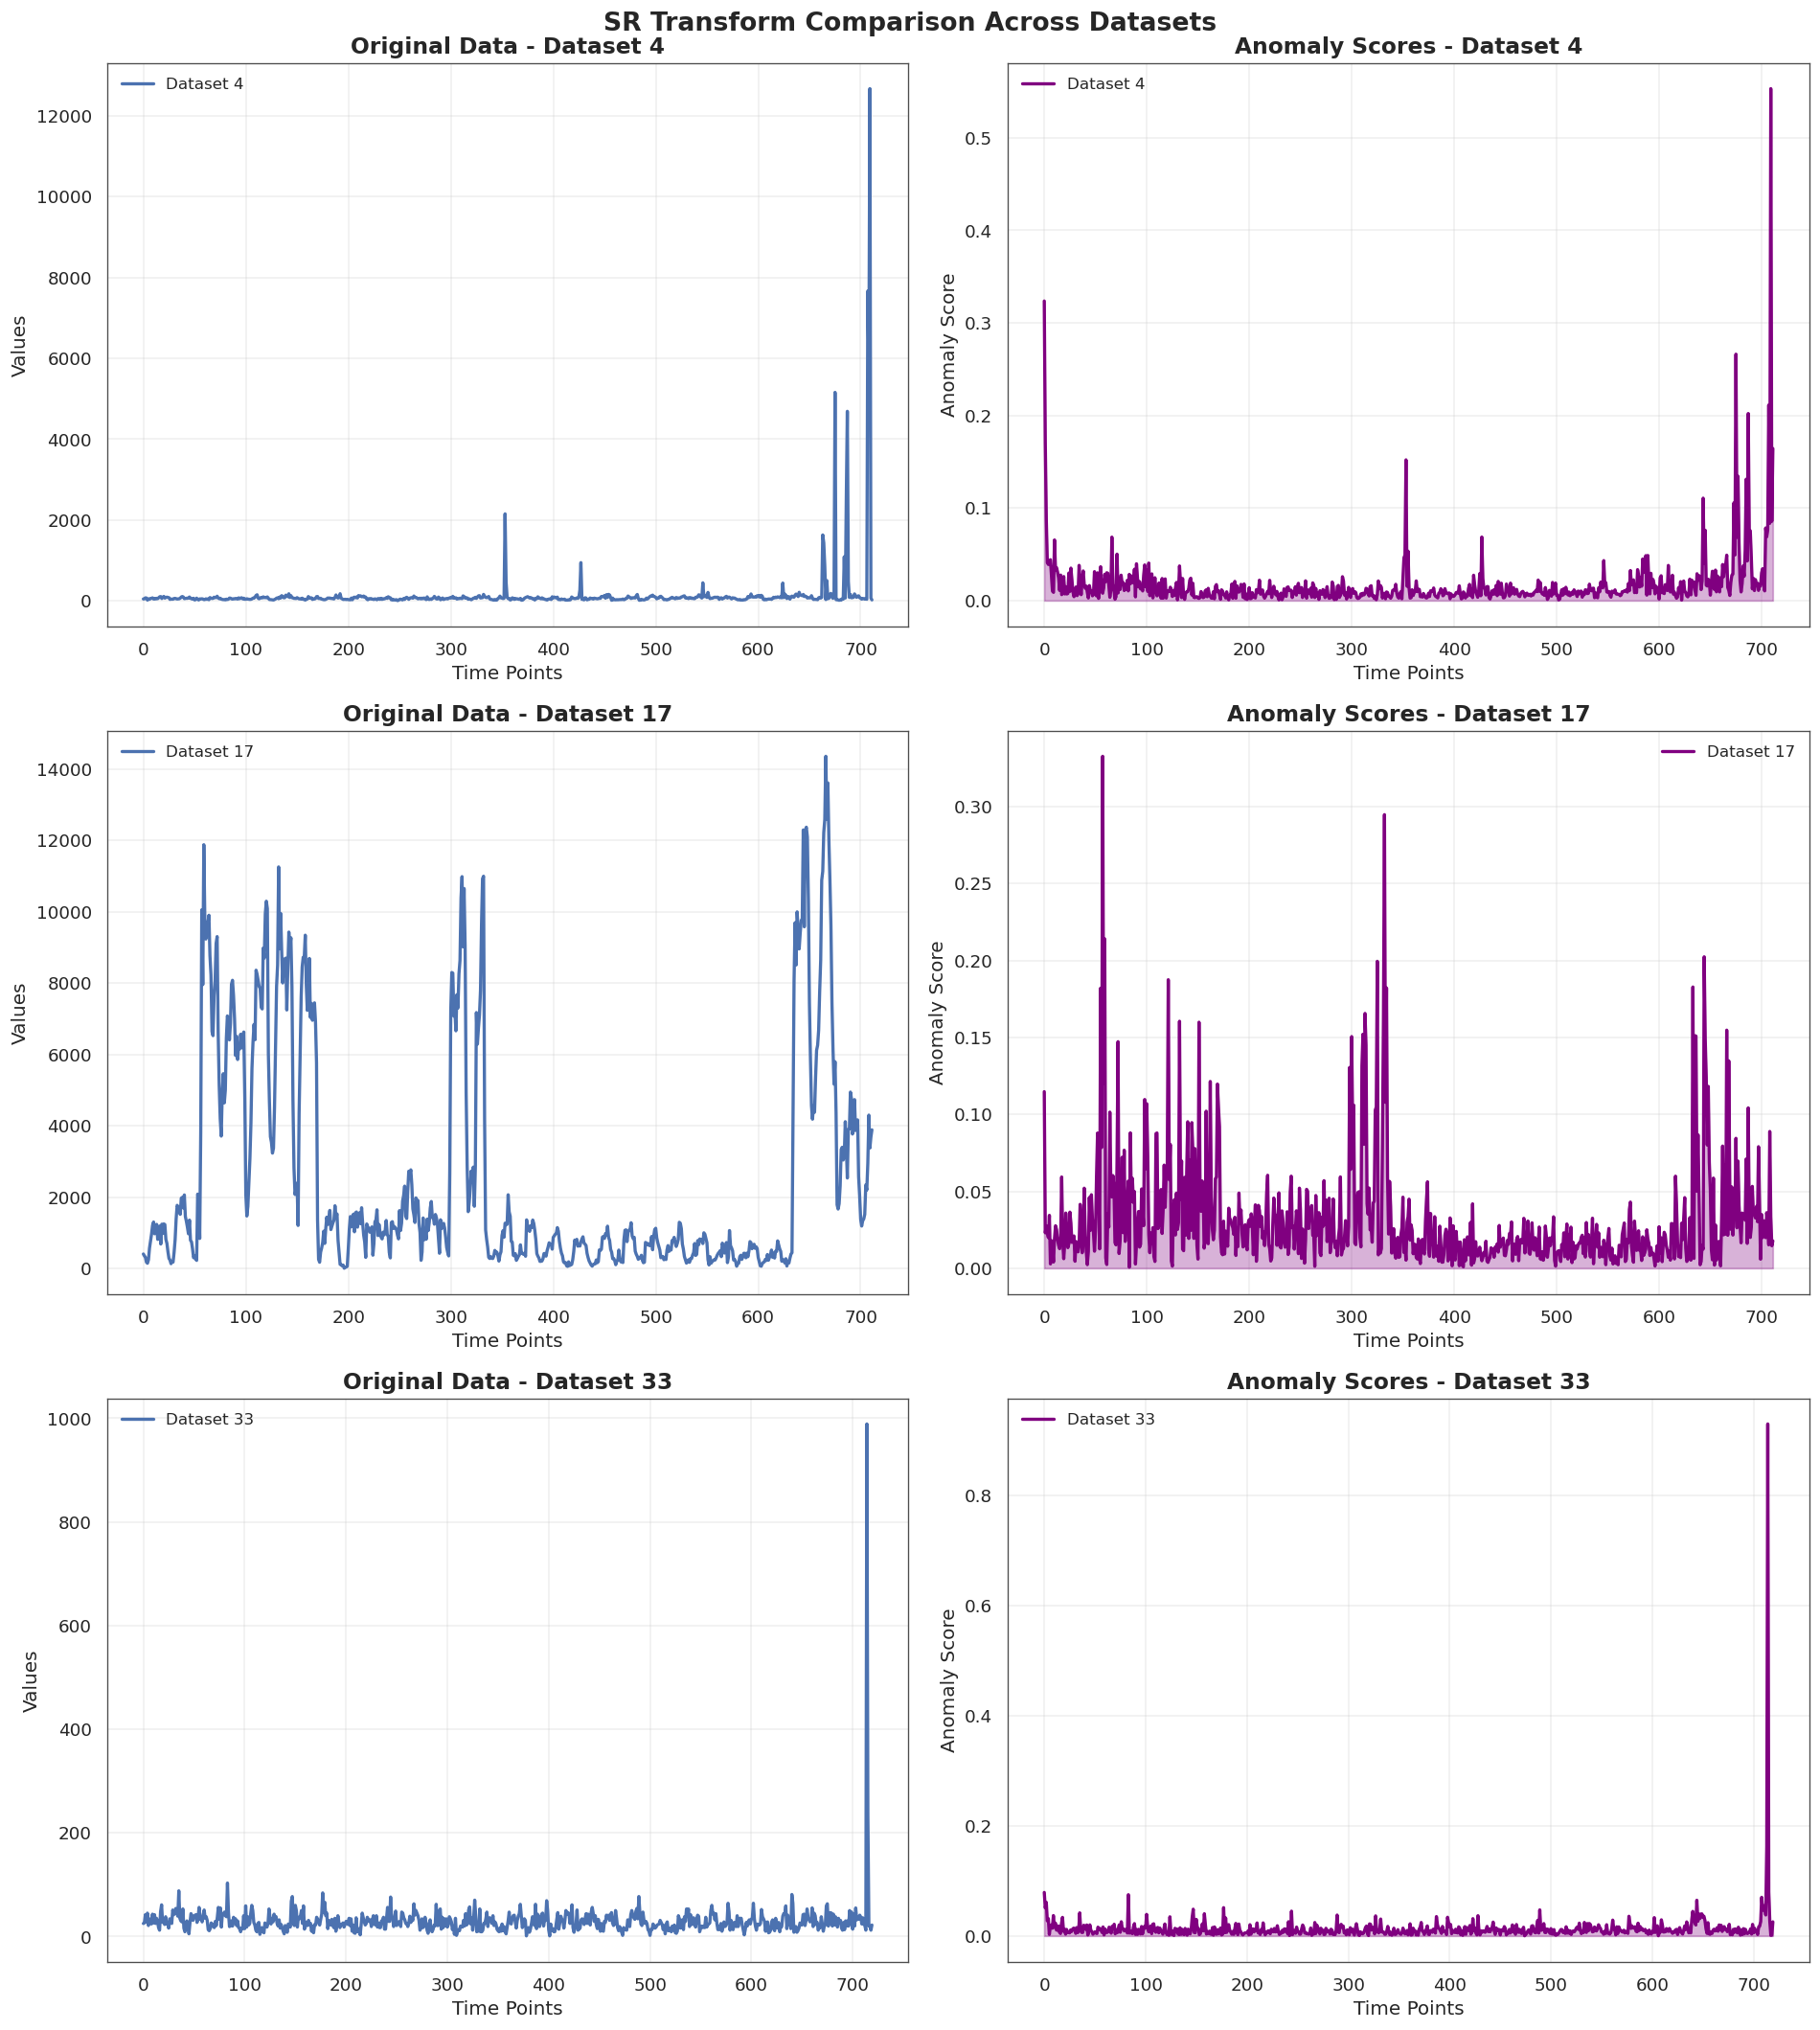

In [4]:
# 演示SR变换可视化
print("=== SR变换可视化演示 ===")

# 选择一个数据集进行详细分析
demo_dataset_id = 4

print(f"\n1. 分析数据集 {demo_dataset_id} 的SR变换过程:")
visualize_sr_transformation(demo_dataset_id)

print(f"\n2. 分析数据集 {demo_dataset_id} 的异常检测结果:")
visualize_anomaly_detection_results(demo_dataset_id)

print(f"\n3. 比较所有数据集的结果:")
compare_multiple_datasets(selected_ids)